In [1]:
import numpy as np
import torch
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
from torchvision.transforms import transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10), # randomly rotate 10 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

In [4]:
%%time

train_data = datasets.CIFAR10('data',
                              train = True,
                              download = True,
                              transform = transform)

test_data = datasets.CIFAR10('data',
                             train = False,
                             download = True,
                             transform = transform)

Files already downloaded and verified
Files already downloaded and verified
CPU times: user 1.99 s, sys: 448 ms, total: 2.44 s
Wall time: 1.73 s


In [5]:
np.random.seed(123)

# Create indices for a validation set (from training set)
validation_size = 0.2

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int((validation_size * num_train)) # 10000
train_idx = indices[split:]
validation_idx = indices[:split]

# define Samplers

train_sampler = SubsetRandomSampler(train_idx) # not initialized with a data source
validation_sampler = SubsetRandomSampler(validation_idx) # not initialized with a data source

# define DataLoaders

# Note: call use an iterator over DataLoaders (e.g. iter(train_loader))

batch_size = 64

train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                          batch_size = batch_size,
                                          sampler = train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset = train_data,
                                               batch_size = batch_size,
                                               sampler = validation_sampler)
test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                         batch_size = batch_size)

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [7]:
class CIFAR10Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # input layer is conv layer that takes in 3x32x32 image(s)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.batch_norm_conv1 = nn.BatchNorm2d(32)
        
        # convolutional layer 2
        self.conv2 = nn.Conv2d(32, 32, (3,3), padding=1) # 3x3 kernel with 1 padding, so H,W dimensions do not change
        self.batch_norm_conv2 = nn.BatchNorm2d(32)
        
        # convolutional layer 3
        self.conv3 = nn.Conv2d(32, 64, (3,3), padding=1)
        self.batch_norm_conv3 = nn.BatchNorm2d(64)
        
        # convolutional layer 4
        self.conv4 = nn.Conv2d(64, 64, (3,3), padding=1)
        self.batch_norm_conv4 = nn.BatchNorm2d(64)
        
        ## convolutional layer 5
        self.conv5 = nn.Conv2d(64, 128, (3,3), padding=1)
        self.batch_norm_conv5 = nn.BatchNorm2d(128)
        
        # conv layer 6
        self.conv6 = nn.Conv2d(128, 128, (3,3), padding=1)
        self.batch_norm_conv6 = nn.BatchNorm2d(128)
        
        # conv 7
        self.conv7 = nn.Conv2d(128, 256, (3,3), padding=1)
        self.batch_norm_conv7 = nn.BatchNorm2d(256)
        
        # conv 8
        self.conv8 = nn.Conv2d(256, 256, (3,3), padding=1)
        self.batch_norm_conv8 = nn.BatchNorm2d(256)
        
        # conv 9
        self.conv9 = nn.Conv2d(256, 512, (3,3), padding=1)
        self.batch_norm_conv9 = nn.BatchNorm2d(512)
        
        # max pooling layer (reduce H,W dimensions)
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        # fully connected Linear layer. Linear layer takes in 1D vector of length in_features
        # So image input must be flattened before going into a Linear layer
        self.fc1 = nn.Linear(in_features=512*4*4, out_features=500) # 128*4*4 is C*H*W
        self.batch_norm_fc1 = nn.BatchNorm1d(500)
        
        # fully connected Linear layer
        self.fc2 = nn.Linear(500, 10) # 10 output features, for the 10 classes in CIFAR10
        
        # dropout layer with p=0.5
        self.dropout = nn.Dropout(0.5)
        # no batch normalization after final fc layer
        
    def forward(self, x):
        x = F.relu(self.batch_norm_conv1(self.conv1(x)))
        x = F.relu(self.batch_norm_conv2(self.conv2(x)))
        x = F.relu(self.batch_norm_conv3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.batch_norm_conv4(self.conv4(x)))
        x = F.relu(self.batch_norm_conv5(self.conv5(x)))
        x = F.relu(self.batch_norm_conv6(self.conv6(x)))
        x = self.pool(x)
        x = F.relu(self.batch_norm_conv7(self.conv7(x)))
        x = F.relu(self.batch_norm_conv8(self.conv8(x)))
        x = F.relu(self.batch_norm_conv9(self.conv9(x)))
        x = self.pool(x)
        
        # Note: in case of a maxpooling layer and relu activation function, 
        #       maxpool(relu(conv(x))) = relu(maxpool(conv(x)))
        #       (relu is an element-wise, monotonically increasing, non-linear function)
        
        # flatten image input
        x = x.view(-1, 512*4*4)
        
        # dropout layer before fully connected Linear layers
        x = self.dropout(x)
        
        # 1st hidden layer with relu activation function
        x = F.relu(self.batch_norm_fc1(self.fc1(x)))
        
        # dropout
        x = self.dropout(x)
        
        # 2nd hidden layer (what activation function?? relu, softmax, log-softmax, ...)
        x = self.fc2(x)
        
        return x
    
model = CIFAR10Network()
print(model)

CIFAR10Network(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm_conv1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm_conv2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm_conv3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm_conv4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm_conv5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_

In [8]:
import torch.optim as optim

In [9]:
%%time

# run after gym, next after this run is to learn how to use pretrained models (udacity course)

model = CIFAR10Network()

if train_on_gpu:
    model.cuda()

# loss function
criterion = nn.CrossEntropyLoss()
'''
PyTorch's cross entropy function applies a softmax funtion to the output layer and then calculates the log loss.

This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
It is useful when training a classification problem with C classes.
If provided, the optional argument weight should be a 1D Tensor assigning weight to each of the classes. 
This is particularly useful when you have an unbalanced training set.
'''

# optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, 
                      weight_decay=0.0005, 
                      nesterov=True) 
#optimizer = optim.Adam(model.parameters(), lr=0.001) # lr=0.001 is default

# LR scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5, verbose=True)

num_epochs = 200
smallest_validation_loss = np.Inf # to track change in validation loss

epochs_without_improvement = 0

train_losses = []
validation_losses = []
for epoch in range(num_epochs):
    
    train_loss = 0
    validation_loss = 0
    validation_num_images, validation_num_correct = 0,0
    
    ##################
    # model training #
    ##################
    model.train() # training mode
    for images, labels in train_loader:
        
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass
        output = model(images) # Note: Avoid calling Module.forward()
        # calculate loss
        loss = criterion(output, labels)
        # Calculate gradients
        loss.backward()
        # optimizer step
        optimizer.step()
        
        # update training loss
        train_loss = train_loss + loss.item()
        
    ###########################    
    # evaluate/validate model #
    ###########################
    with torch.no_grad(): # Turn off gradients for validation, saves memory and computations. Turns off autograd.
        model.eval() # evaluation mode
        for images, labels in validation_loader:
            
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()

            valid_output = model(images)
            
            # compute loss
            loss = criterion(valid_output, labels)
            validation_loss = validation_loss + loss.item()
            
            # compute accuracy
            scores, predictions = torch.max(valid_output,1)
            validation_num_images = validation_num_images + len(predictions)
            validation_num_correct = validation_num_correct + sum(predictions == labels).item()
            
    avg_train_loss = train_loss/len(train_loader.dataset)
    avg_validation_loss = validation_loss/len(validation_loader.dataset)
    train_losses.append(avg_train_loss)
    validation_losses.append(avg_validation_loss)
    
    scheduler.step(avg_validation_loss)
    
    loss_message = ''
    if avg_validation_loss <= smallest_validation_loss:
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'model_CIFAR10.pt')
        smallest_validation_loss = avg_validation_loss
        loss_message = 'Validation Loss Decreased, Saved Model'
    else:
        epochs_without_improvement = epochs_without_improvement + 1
    
    print('Epoch %d/%d' % (epoch+1, num_epochs),
          'Avg Train Loss: %f' % avg_train_loss,
          'Avg Validation Loss: %f' % avg_validation_loss,
          loss_message)
    
    print('Validation Accuracy: %d/%d = %f' % (validation_num_correct, validation_num_images, 
                                               validation_num_correct/validation_num_images))
    
    if epochs_without_improvement == 20:
        print('20 epochs without improvement, ending training...')
        break

Epoch 1/200 Avg Train Loss: 0.020528 Avg Validation Loss: 0.004174 Validation Loss Decreased, Saved Model
Validation Accuracy: 5196/10000 = 0.519600
Epoch 2/200 Avg Train Loss: 0.014328 Avg Validation Loss: 0.003392 Validation Loss Decreased, Saved Model
Validation Accuracy: 6236/10000 = 0.623600
Epoch 3/200 Avg Train Loss: 0.012107 Avg Validation Loss: 0.002982 Validation Loss Decreased, Saved Model
Validation Accuracy: 6635/10000 = 0.663500
Epoch 4/200 Avg Train Loss: 0.011002 Avg Validation Loss: 0.002671 Validation Loss Decreased, Saved Model
Validation Accuracy: 7003/10000 = 0.700300
Epoch 5/200 Avg Train Loss: 0.010349 Avg Validation Loss: 0.003416 
Validation Accuracy: 6407/10000 = 0.640700
Epoch 6/200 Avg Train Loss: 0.009759 Avg Validation Loss: 0.002757 
Validation Accuracy: 6980/10000 = 0.698000
Epoch 7/200 Avg Train Loss: 0.009329 Avg Validation Loss: 0.002690 
Validation Accuracy: 7131/10000 = 0.713100
Epoch 8/200 Avg Train Loss: 0.008959 Avg Validation Loss: 0.002726 
Val

Epoch 68/200 Avg Train Loss: 0.003263 Avg Validation Loss: 0.001467 
Validation Accuracy: 8503/10000 = 0.850300
Epoch 69/200 Avg Train Loss: 0.003322 Avg Validation Loss: 0.001365 
Validation Accuracy: 8559/10000 = 0.855900
Epoch 70/200 Avg Train Loss: 0.003256 Avg Validation Loss: 0.001354 
Validation Accuracy: 8551/10000 = 0.855100
Epoch 71/200 Avg Train Loss: 0.003192 Avg Validation Loss: 0.001230 Validation Loss Decreased, Saved Model
Validation Accuracy: 8704/10000 = 0.870400
Epoch 72/200 Avg Train Loss: 0.003255 Avg Validation Loss: 0.001420 
Validation Accuracy: 8536/10000 = 0.853600
Epoch 73/200 Avg Train Loss: 0.003209 Avg Validation Loss: 0.001468 
Validation Accuracy: 8453/10000 = 0.845300
Epoch 74/200 Avg Train Loss: 0.003224 Avg Validation Loss: 0.001449 
Validation Accuracy: 8486/10000 = 0.848600
Epoch 75/200 Avg Train Loss: 0.003148 Avg Validation Loss: 0.001332 
Validation Accuracy: 8596/10000 = 0.859600
Epoch 76/200 Avg Train Loss: 0.003175 Avg Validation Loss: 0.00145

Epoch 136/200 Avg Train Loss: 0.000108 Avg Validation Loss: 0.000932 Validation Loss Decreased, Saved Model
Validation Accuracy: 9162/10000 = 0.916200
Epoch 137/200 Avg Train Loss: 0.000123 Avg Validation Loss: 0.000947 
Validation Accuracy: 9159/10000 = 0.915900
Epoch 138/200 Avg Train Loss: 0.000105 Avg Validation Loss: 0.000935 
Validation Accuracy: 9156/10000 = 0.915600
Epoch 139/200 Avg Train Loss: 0.000102 Avg Validation Loss: 0.000912 Validation Loss Decreased, Saved Model
Validation Accuracy: 9195/10000 = 0.919500
Epoch 140/200 Avg Train Loss: 0.000096 Avg Validation Loss: 0.000937 
Validation Accuracy: 9174/10000 = 0.917400
Epoch 141/200 Avg Train Loss: 0.000097 Avg Validation Loss: 0.000923 
Validation Accuracy: 9182/10000 = 0.918200
Epoch 142/200 Avg Train Loss: 0.000096 Avg Validation Loss: 0.000993 
Validation Accuracy: 9154/10000 = 0.915400
Epoch 143/200 Avg Train Loss: 0.000090 Avg Validation Loss: 0.000954 
Validation Accuracy: 9147/10000 = 0.914700
Epoch 144/200 Avg Tr

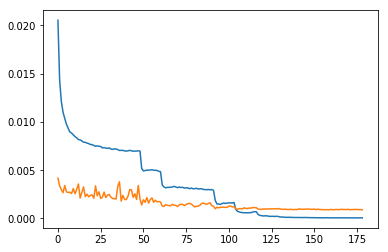

In [10]:
plt.plot(train_losses) 
plt.plot(validation_losses)

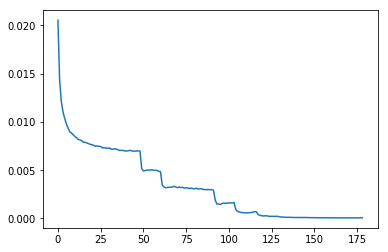

In [11]:
plt.plot(train_losses)

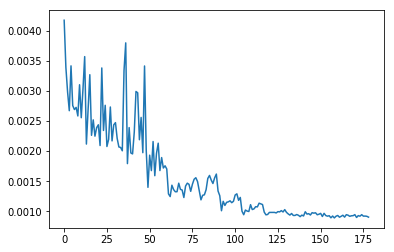

In [12]:
plt.plot(validation_losses)

In [13]:
%%time

state_dict = torch.load('model_CIFAR10.pt')
model.load_state_dict(state_dict)

CPU times: user 8 ms, sys: 24 ms, total: 32 ms
Wall time: 30.8 ms


# Evaluate accuracy on Test Set of 10,000 points

In [14]:
with torch.no_grad():
    model.eval()
    
    test_loss = 0
    num_images, num_correct = 0,0
    
    for images, labels in test_loader:
        
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        
        output = model(images) # output is class scores
        
        # compute loss
        loss = criterion(output, labels)
        test_loss = test_loss + loss.item()
        
        # compute accuracy
        scores, predictions = torch.max(output,1)
        
        num_images = num_images + len(predictions)
        num_correct = num_correct + sum(predictions == labels).item()

    avg_test_loss = test_loss/len(test_loader.dataset)
    print('Avg Loss: %f' % avg_test_loss,
          'Test Accuracy: %d/%d = %f' % (num_correct, num_images, num_correct/num_images))

Avg Loss: 0.004373 Test Accuracy: 9194/10000 = 0.919400


Test Accuracy of 91.94%